In [1]:
############################
## QAC 307 Final Project
############################

In [1]:
import os
import math
import numpy as np
import pandas as pd
import cv2 as cv
import imutils

from matplotlib import pyplot as plt
from scipy.interpolate import splprep, splev
from PIL import Image 
from pathlib import Path

import jupyterthemes as jt
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme

In [2]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
set_nb_theme('oceans16')

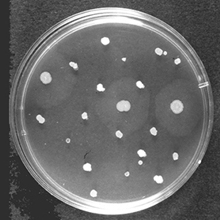

In [5]:
sample_path = r"C:\Users\olive\Documents\QAC 307\images\sample.jpg"

img = cv.imread(sample_path,cv.COLOR_RGB2BGR)
gs = cv.imread(sample_path, cv.IMREAD_GRAYSCALE)

Image.fromarray(gs)

In [6]:
gs

array([[46, 46, 46, ..., 59, 63, 71],
       [46, 46, 46, ..., 73, 54, 64],
       [46, 46, 46, ..., 70, 63, 68],
       ...,
       [46, 46, 46, ..., 51, 57, 68],
       [46, 46, 46, ..., 51, 65, 71],
       [46, 46, 46, ..., 55, 67, 70]], dtype=uint8)

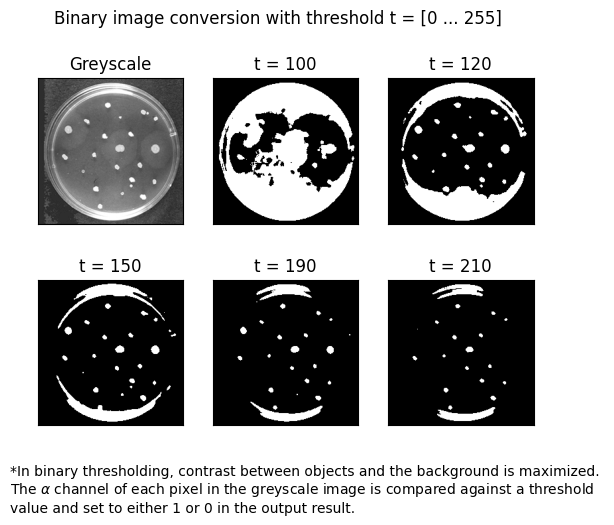

In [7]:
## Convert greyscale image to binary 

## Thresholding 
gs = cv.imread(sample_path, cv.IMREAD_GRAYSCALE)
gs_b = cv.medianBlur(gs,5)

ret,thresh1 = cv.threshold(gs_b,100,255,cv.THRESH_BINARY)
ret,thresh2 = cv.threshold(gs_b,120,255,cv.THRESH_BINARY)
ret,thresh3 = cv.threshold(gs_b,150,255,cv.THRESH_BINARY)
ret,thresh4 = cv.threshold(gs_b,190,255,cv.THRESH_BINARY)
ret,thresh5 = cv.threshold(gs_b,210,255,cv.THRESH_BINARY)

# plot
cap = '*In binary thresholding, contrast between objects and the background is maximized. '\
'\n' + r'The $\alpha$ channel of each pixel in the greyscale image is compared against a '\
'threshold \nvalue and set to either 1 or 0 in the output result.'
titles = ['Greyscale','t = 100','t = 120','t = 150','t = 190','t = 210']
images = [gs, thresh1, thresh2, thresh3, thresh4, thresh5]
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.suptitle('Binary image conversion with threshold t = [0 ... 255]', size=12, y=1.0)
plt.text(-570, 350, cap)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.show()

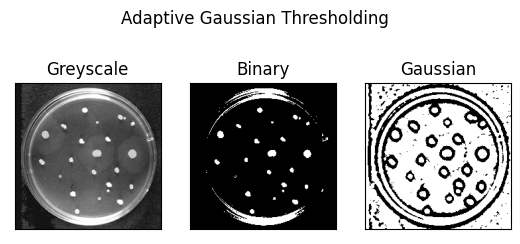

In [13]:
## Gaussian thresholding for dish perimeter
blur = cv.GaussianBlur(gs, (9,9), 0)

ret,th1 = cv.threshold(gs,190,255,cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(blur,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)

# plot
titles = ['Greyscale', 'Binary','Gaussian']
images = [gs, th1, th2]
for i in range(3):
    plt.subplot(1,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.suptitle('Adaptive Gaussian Thresholding', size=12, y=0.8)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.5)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


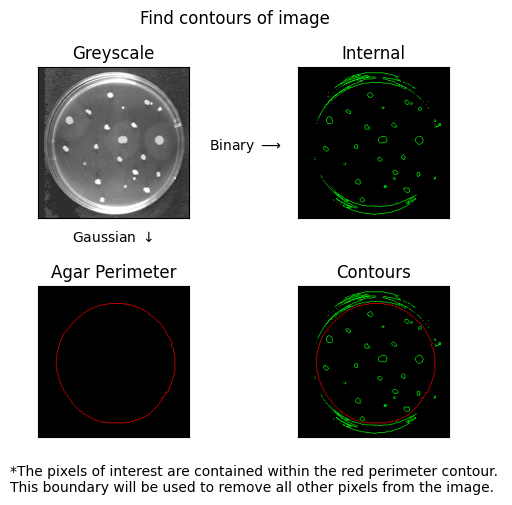

In [9]:
## Contours

## Scale contour function
def scale_contour(cnt, scale):
    M = cv.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    cnt_norm = cnt - [cx, cy]
    cnt_scaled = cnt_norm * scale
    cnt_scaled = cnt_scaled + [cx, cy]
    cnt_scaled = cnt_scaled.astype(np.int32)

    return cnt_scaled

#create an empty images for contours
gs_copy = gs.copy()
img_copy = img.copy()
img_contours = np.zeros(img.shape)
ext_contours = np.zeros(img.shape)
comb_contours = np.zeros(img.shape)
masking_img = gs.copy()
scale_ex = np.zeros(img.shape)

## Masking
stencil = np.zeros(gs_copy.shape).astype(gs_copy.dtype)
stencil_1 = np.zeros(gs_copy.shape).astype(gs_copy.dtype)
color = [255, 255, 255]

##Internal contours
contours, hierarchy = cv.findContours(th1, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
int_conts = contours

# draw the internal contours on the empty image
cv.drawContours(img_contours, contours, -1, (0,255,0), 1)
cv.drawContours(img_copy, contours, -1, (0,255,0), 1)
cv.drawContours(scale_ex, contours, -1, (0,255,0), 1)
final_conts_img = img_contours.copy()

##Perimeter contour
thresh = cv.adaptiveThreshold(blur,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,23,3)

cnts = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# draw perimeter contour
lst = []
for c in cnts: # Get contour with greatest area
    area = cv.contourArea(c)
    lst.append(area)
ext_bound = max(lst)

## Scale perimeter contour by 0.98 to remove spurious non-zero pixels and draw on images
cont_ext = -1
for c in cnts:
    area = cv.contourArea(c)
    if area == ext_bound:
        cont_ext = c
        cv.drawContours(final_conts_img, [scale_contour(c, 0.98)], -1, (255,0,0), 1)
        cv.drawContours(ext_contours, [scale_contour(c, 0.98)], -1, (255,0,0), 1)
        cv.fillPoly(stencil, [scale_contour(c, 0.98)], color)
        cv.fillPoly(stencil_1, [c], color)
        cv.drawContours(masking_img, [scale_contour(c, 0.98)], -1, (255,0,0), 1)
        cv.drawContours(scale_ex, [scale_contour(c, 0.98)], -1, (255, 191, 0), 1)
        cv.drawContours(scale_ex, [c], -1, (255,0,0), 1)
        
## Masking        
result = cv.bitwise_and(gs_copy, stencil)
result_bad = cv.bitwise_and(gs_copy, stencil_1)
final = result.copy()
cv.drawContours(final, contours, -1, (0,255,0), 1)


# plot 
titles = ['Greyscale', 'Internal', 'Agar Perimeter', 'Contours']
images = [gs, img_contours, ext_contours, final_conts_img]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([]) 
plt.suptitle('Find contours of image', size=12, y=1)
plt.text(-130, -200, r'Binary $\longrightarrow$')
plt.text(-330, -65, r'Gaussian $\downarrow$')
plt.text(-420, 300, "*The pixels of interest are contained within the red perimeter contour. \n"\
        "This boundary will be used to remove all other pixels from the image.")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.45)
plt.show()

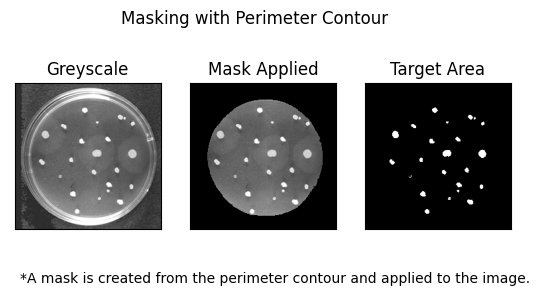

In [10]:
## Remove pixels beyond perimeter

ret,thresh_f = cv.threshold(result,190,255,cv.THRESH_BINARY)

# plot 
titles = ['Greyscale','Mask Applied', 'Target Area']
images = [gs, result, thresh_f]

for i in range(3):
    plt.subplot(1,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.suptitle('Masking with Perimeter Contour', size=12, y=0.8)
plt.text(-520, 300, "*A mask is created from the perimeter contour and applied to the image.")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


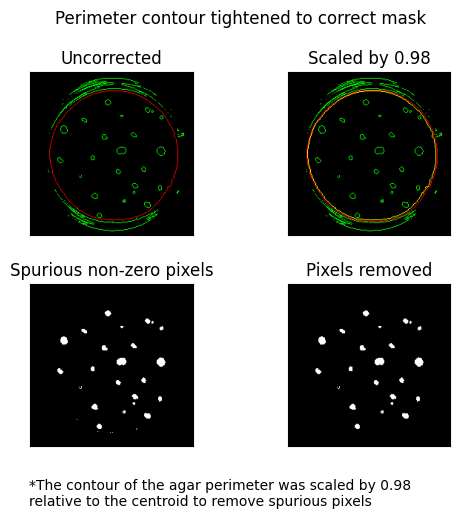

In [11]:
## Scale perimeter contour

# Contour of perimeter boundary is scaled by 0.98 relative to original centroid 
ret,thresh_bad = cv.threshold(result_bad,190,255,cv.THRESH_BINARY)
ret,thresh_f = cv.threshold(result,190,255,cv.THRESH_BINARY)

# plot 
titles = ['Uncorrected', 'Scaled by 0.98', 'Spurious non-zero pixels', 'Pixels removed']
images = [final_conts_img, scale_ex, thresh_bad, thresh_f]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.suptitle('Perimeter contour tightened to correct mask', size=12, y=1.01)
plt.text(-350, 300, "*The contour of the agar perimeter was scaled by 0.98 \nrelative to "\
        "the centroid to remove spurious pixels")
plt.subplots_adjust(left=0.1, bottom=0.1, right=None, top=None, wspace=0.01, hspace=0.3)
plt.show()



In [ ]:
########################################
## Experimental Results
########################################

In [ ]:
## Functions

######################################
# Image processing

#Image to greyscale
def get_gs(path):
    gs = cv.imread(path, cv.IMREAD_GRAYSCALE)
    return gs

#Blur image
def get_blur(image, value=9):
    blur = cv.GaussianBlur(image, (value,value), 0) #Gaussian blur applied 
    return blur
        
#Image to binary Gaussian thresholding
def get_gaus(image):
    thresh = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 23,3)
    return thresh
    
#Image to binary Otsu thresholding
def get_otsu(image):
    blur = cv.GaussianBlur(image, (7,7), 0) #Gaussian blur applied 
    (T, thresh ) = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
    return thresh
    
#Image to binary from path
def get_binary(path):
    gs = cv.imread(path, cv.IMREAD_GRAYSCALE)
    ret, thresh = cv.threshold(gs,200,255,cv.THRESH_BINARY)
    return thresh

#Image to binary from array
def get_binary_from_array(image, threshold_value=190):
    ret, thresh = cv.threshold(image, threshold_value, 255, cv.THRESH_BINARY)
    return thresh

#Get grand plate binary
def get_grand(image):
    contrasted_img = cv.equalizeHist(cv.GaussianBlur(image, (19,19), 0)) 
    grand = get_binary_from_array(contrasted_img, 110)
    return grand

#Save binary images
def save_binary(images_dir):
    os.chdir(binary_dir)
    #Loop through images
    for image in os.listdir(images_dir):
        path = os.path.join(images_dir, image)
        binary_img = get_binary(path)
        binary_result = Image.fromarray(binary_img)  
        #Save binary image
        with binary_result as f:
            f.save(Path("binary_" + image).stem + '.png')
    os.chdir(r"C:\Users\olive\Documents\QAC 307\images")

######################################
# Contours

#Get external contours
def get_ext_conts(image):
    contours, hierarchy = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    return contours, hierarchy    

#Get internal contours
def get_conts(image):
    contours, hierarchy = cv.findContours(image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    return contours, hierarchy

#Find grand countour
def get_grand_cont_area(contours):
    lst = []
    for c in contours: # Get contour with greatest area
        area = cv.contourArea(c)
        lst.append(area)
    area_max = max(lst)
    return area_max

#Smooth contour
def smooth_conts(contours):
    smoothened = []
    for contour in contours:
        x,y = contour.T
        # Convert from numpy arrays to normal arrays
        x = x.tolist()[0]
        y = y.tolist()[0]
        tck, u = splprep([x,y], u=None, s=1.0, per=1)
        u_new = np.linspace(u.min(), u.max(), 25)
        x_new, y_new = splev(u_new, tck, der=0)
        # Convert it back to numpy format for opencv to be able to display it
        res_array = [[[int(i[0]), int(i[1])]] for i in zip(x_new,y_new)]
        smoothened.append(np.asarray(res_array, dtype=np.int32))
    return(smoothened)

#Draw contours
def draw_conts(image, target_img, retr="tree"):
    if retr == "ext":
        contours, hierarchy = get_ext_conts(image)
        cv.drawContours(target_img, contours, -1, (0,255,0), 1)
    elif retr == "tree":
        contours, hierarchy = get_conts(image)
        cv.drawContours(target_img, contours, -1, (0,255,0), 1)

#Find agar perimeter
def get_bounds(image):
    blur = cv.GaussianBlur(image, (15,15), 0)
    ret, thresh = cv.threshold(image,185,255,cv.THRESH_BINARY)
    #thresh = get_gaus(image) # Gaussian image
    cnts = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    # Perimeter contour
    lst = []
    for c in cnts: # Get contour with greatest area
        area = cv.contourArea(c)
        lst.append(area)
    area_max = max(lst)
    return cnts, area_max

#Scale contour function
def scale_contour(cnt, scale):
    M = cv.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    cnt_norm = cnt - [cx, cy]
    cnt_scaled = cnt_norm * scale
    cnt_scaled = cnt_scaled + [cx, cy]
    cnt_scaled = cnt_scaled.astype(np.int32)
    return cnt_scaled

#Draw perimeter contour
def draw_bounds(target_img, contours, scale=False):
    bound_area = get_grand_cont_area(contours)
    # Loop through contours and draw largest as perimeter
    if scale == True:
        for c in contours:
            area = cv.contourArea(c)
            if area == bound_area:
                cv.drawContours(target_img, [scale_contour(c, 0.98)], -1, (255,0,0), 1)
            else:
                pass
    elif scale != True:
        for c in contours:
            area = cv.contourArea(c)
            if area == bound_area:
                cv.drawContours(target_img, [c], -1, (255,0,0), 1)
            else:
                pass

#Approximate contour
def approx_cont(contours):
    cnts = imutils.grab_contours(contours)
    c = max(cnts, key=cv.contourArea)
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.0001 * peri, True)
    return approx
            
#Fit ellipse to contour
def draw_ellipse(target_image, contours):
    color = [255, 255, 255]
    minEllipse = [None]*len(contours)
    ellipse_area = [None]*len(contours)
    result = -1
    
    for i, c in enumerate(contours):
        area = cv.contourArea(c)
        if area <= 100:  # skip ellipses smaller then 10x10
            continue
        if c.shape[0] > 2500:
            ellipse = cv.fitEllipse(c)
            x = ellipse[0][0]  # center x
            y = ellipse[0][1]  # center y
            angle = ellipse[2]  # angle
            a_min = ellipse[1][0]  # asse minore
            a_max = ellipse[1][1]
            a = int(a_max / 2)
            b = int(a_min / 2)
            ecc = (np.sqrt((a**2) - (b**2)) / a)
            if ecc < 0.3:
                minEllipse[i] = ellipse
                ellipse_area[i] = (ellipse[1][0]/2.0) * (ellipse[1][1]/2.0) * math.pi
                
    min_area = min([i for i in ellipse_area if i != None])
    
    for i, c in enumerate(contours):
        if ellipse_area[i] == min_area:
            result = minEllipse[i]
            cv.ellipse(target_image, minEllipse[i], color, 2)
        
            return result
       

In [251]:
######################################
# Masking

#Apply mask to image
def apply_mask(image, mask_contour, scale=1.0):
    color = [255, 255, 255]
    stencil =  np.zeros(image.shape, image.dtype)
    bound_area = get_grand_cont_area(mask_contour)
    for c in mask_contour:
        area = cv.contourArea(c)
        if area == bound_area:
            cv.fillPoly(stencil, [scale_contour(c, scale)], color)
        else:
            pass
    result = cv.bitwise_and(image, stencil)
    return result

#Get masked plate image
def get_masked_grand(image, scale=1.0):
    masked = image
    grand_binary = get_grand(masked)
    mask_cont = get_conts(grand_binary)[0]
    result = apply_mask(masked, mask_cont, scale)
    return result
    
#Ellipse mask
def apply_ellipse_mask(ellipse, image):
    color = [255, 255, 255]
    stencil =  np.zeros(image.shape, image.dtype)
    x = ellipse[0][0]  # center x
    y = ellipse[0][1]  # center y
    angle = ellipse[2]  # angle
    a_min = ellipse[1][0]  # asse minore
    a_max = ellipse[1][1]
    a = int(a_max / 2)
    b = int(a_min / 2)
    a = int(a*0.98)
    b = int(b*0.98)
    poly = cv.ellipse2Poly((int(ellipse[0][0]), int(ellipse[0][1])), (b, a), int(ellipse[2]), 0, 360, 5)
    cv.fillPoly(stencil, [poly], 255)
    result = cv.bitwise_and(image, stencil)
    return result

#Get final masked binary images    
def mask_binary(image, binary):
    masked = get_masked_grand(image, scale=0.95) #Grand plate perimeter
    blur = get_blur(get_binary_from_array(masked, threshold_value=200), value=15) #Gaussian blur and binary thresholding
    blur = cv.equalizeHist(blur) #Contrast
    gaus = get_gaus(blur)
    conts = get_conts(gaus)
    ellipse_array = draw_ellipse(image, conts[0])
    result = apply_ellipse_mask(ellipse_array, binary)
    return result
    
    
#Save masked binary
def save_masked_as_binary(lst):
    os.chdir(r"C:\Users\olive\Documents\QAC 307\images\images_binary_masked")
    for i,img in enumerate(lst):
        binary_img = get_binary_from_array(img, threshold_value=205)
        binary_result = Image.fromarray(binary_img) 
        with binary_result as f:
            f.save(Path("binary_" + f"{i+1}").stem + '.png')
    
#############################
## Area calculations

#Calculate area from non-zero pixels
def get_area(arr):
    area = cv.countNonZero(arr)
    return area    
        
        

In [164]:
#######################################
## Area calculation
#######################################

In [280]:
## Directories 

#Images
img_dir = r"C:\Users\olive\Documents\QAC 307\images\images_data" #Unmodified images
binary_dir = r"C:\Users\olive\Documents\QAC 307\images\images_binary_masked" #Binary images


In [281]:
area_lst = []
for i in range(1,19):
    img = f"binary_{i}"
    path = os.path.join(binary_dir, f"{img}.png")
    arr = get_binary(path)
    area = get_area(arr)
    area_lst.append(area)
    print(area, img)

5072 binary_1
13098 binary_2
20247 binary_3
16500 binary_4
6695 binary_5
16438 binary_6
23926 binary_7
11473 binary_8
35428 binary_9
17890 binary_10
10758 binary_11
33088 binary_12
25549 binary_13
20358 binary_14
21955 binary_15
48781 binary_16
66536 binary_17
30833 binary_18


In [ ]:
###############################
## Make figures
###############################

In [4]:
control_path = r"C:\Users\olive\Documents\QAC 307\images\control"
uv_high_path = r"C:\Users\olive\Documents\QAC 307\images\uv_high"
uv_low_path = r"C:\Users\olive\Documents\QAC 307\images\uv_low"

In [19]:
control_images = []
for file in os.listdir(control_path):
    path = os.path.join(control_path, file)
    img = cv.imread(path)
    control_images.append(img)

In [21]:
control_images[0].shape

(1666, 1960, 3)

In [14]:
uv_high_images = []
for file in os.listdir(uv_high_path):
    path = os.path.join(uv_high_path, file)
    img = cv.imread(path)
    uv_high_images.append(img)

In [15]:
uv_low_images = []
for file in os.listdir(uv_low_path):
    path = os.path.join(uv_low_path, file)
    img = cv.imread(path)
    uv_low_images.append(img)

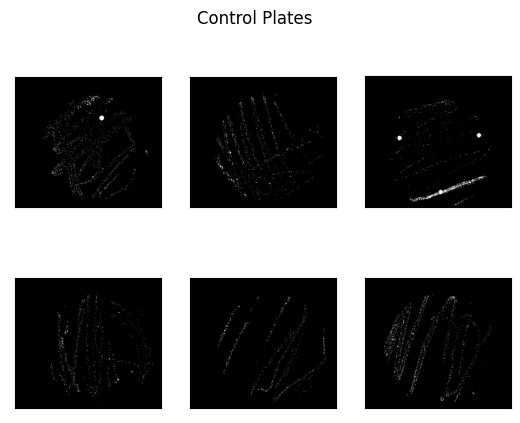

In [29]:
cap = 'Control Plates'

images = control_images
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i][0:1600, 0:1800])
    plt.xticks([]),plt.yticks([])
plt.suptitle(cap)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.show()

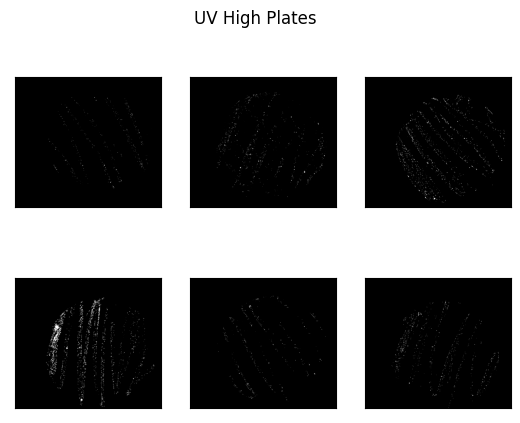

In [31]:
cap = 'UV High Plates'

images = uv_high_images
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i][0:1600, 0:1800])
    plt.xticks([]),plt.yticks([])
plt.suptitle(cap)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.show()

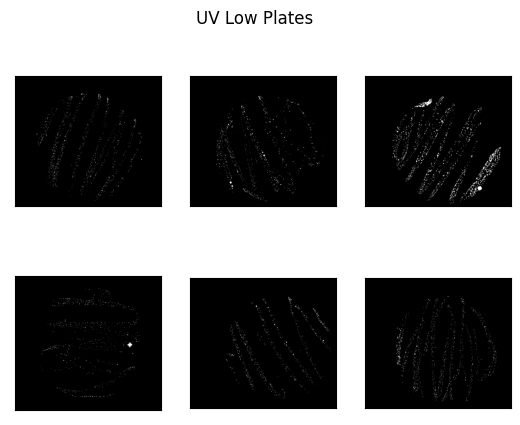

In [32]:
cap = 'UV Low Plates'

images = uv_low_images
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i][0:1600, 0:1800])
    plt.xticks([]),plt.yticks([])
plt.suptitle(cap)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.show()